<center><img src="https://miro.medium.com/v2/resize:fit:300/0*gTbWMTKvNF-jLJrM.jpg" width=30% ></center>

# <center> Assignment 3: Harris Corner Detector & Optical Flow </center>
<center> Computer Vision 1, University of Amsterdam </center>
    <center> Due 23:59PM, September 30, 2023 (Amsterdam time) </center>
    
  ***
<center>
<b>TA's: Melis Öcal, Ronny Velastegui Sandoval</b>

Student1 ID: 15096157\
Student1 Name: Nordin Belkacemi

Student2 ID: 13740512\
Student2 Name: Max Belitsky

Student3 ID: 12556963\
Student3 Name: Thomas Komen


# General Guidelines

Your code and discussion must be handed in this jupyter notebook, renamed to **StudentID1_StudentID2_StudentID3.ipynb** before the deadline by submitting it to the Canvas Lab 3 Assignment. Please also fill out your names and ID's above.

For full credit, make sure your notebook follows these guidelines:
- It is mandatory to use the Python environment provided with the assignment; the environment specifies the package versions that have to be used to prevent the use of particular functions. Using different packages versions may lead to grade deduction. In the 'Environment Setup' below you can check whether your environment is set up correctly.
- To install the environment with the right package versions, use the following command in your terminal: ```python
conda env create --file=CV1_environment.yaml```, then activate the environment using the command ```python conda activate cv1```.
- Please express your thoughts concisely. The number of words does not necessarily correlate with how well you understand the concepts.
- Answer all given questions and sub-questions.
- Try to understand the problem as much as you can. When answering a question, give evidences (qualitative and/or quantitative results, references to papers, figures etc.) to support your arguments. Note that not everything might be explicitly asked for and you are expected to think about what might strengthen you arguments and make the notebook self-contained and complete.
- Tables and figures must be accompanied by a brief description. Do not forget to add a number, a title, and if applicable name and unit of variables in a table, name and unit of axes and legends in a figure.

__Note:__ A more complete overview of the lab requirements can be found in the Course Manual on Canvas

Late submissions are not allowed. Assignments that are submitted after the strict deadline will not be graded. In case of submission conflicts, TAs’ system clock is taken as reference. We strongly recommend submitting well in advance, to avoid last minute system failure issues.

Plagiarism note: Keep in mind that plagiarism (submitted materials which are not your work) is a serious crime and any misconduct shall be punished with the university regulations. This includes the use of generative tools such as ChatGPT.

**ENSURE THAT YOU SAVE ALL RESULTS / ANSWERS ON THE QUESTIONS (EVEN IF YOU RE-USE SOME CODE).**

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import signal
from scipy.ndimage import maximum_filter
from scipy import signal
import os
import matplotlib
import scipy
from PIL import Image

In [4]:
# Make sure you're using the provided environment!
assert cv2.__version__ == "3.4.2", "You're not using the provided Python environment!"
assert np.__version__ == "1.19.5", "You're not using the provided Python environment!"
assert matplotlib.__version__ == "3.3.4", "You're not using the provided Python environment!"
assert scipy.__version__ == "1.5.4", "You're not using the provided Python environment!"
# Proceed to the next cell if you don't get any error.

# 1. Harris Corner Detector (45pts)
In this section, a derivation of the *[Harris Corner Detector](https://www.semanticscholar.org/paper/A-Combined-Corner-and-Edge-Detector-Harris-Stephens/6818668fb895d95861a2eb9673ddc3a41e27b3b3)* is presented.

Given a shift $(\Delta x,\Delta y)$ at a point $(x, y)$, the auto-correlation function is defined as:

$$c(\Delta x,\Delta y) = \sum\limits_{(x,y)\in W(x,y)} {w(x,y)(I(x+\Delta x,y+\Delta y)-I(x,y))^2} \tag {1}$$

where $W(x,y)$ is a window centered at point $(x,y)$ and $w(x,y)$ is a Gaussian function. For simplicity, from now on, $\sum\limits_{(x,y)\in W(x,y)}$ will be referred to as $\sum\limits_{W}$.
Approximating the shifted function by the first-order Taylor expansion we get:

\begin{eqnarray}
I(x+\Delta x,y+ \Delta y) & \approx & I(x,y) + I_x(x,y)\Delta x + I_y(x,y)\Delta y \tag {2} \\
&=& I(x,y) + [I_x(x,y) \ I_y(x,y)] \begin{bmatrix} \Delta x \\ \Delta y \end{bmatrix}, \tag {3}
\end{eqnarray}

where $I_x$ and $I_y$ are partial derivatives of $I(x,y)$. The first gradients can be approximated by:
\begin{eqnarray}
    I_x &=& \frac{\partial I}{\partial x} \approx I * G_x, \quad G_x = (-1,0,1) \tag {4} \\
    I_y &=& \frac{\partial I}{\partial y} \approx I * G_y, \quad G_y = (-1,0,1)^T \tag {5}
\end{eqnarray}


Note that using the kernel $(-1, 1)$ to approximate the gradients is also correct. The auto-correlation function can now be written as:
\begin{eqnarray}
c(\Delta x,\Delta y) &=& \sum\limits_{W} {w(x,y) (I(x+\Delta x,y+\Delta y)-I(x,y))^2} \tag {6} \\
& \approx & \sum\limits_{W} {w(x,y) ([I_x(x,y) \ I_y(x,y)]\begin{bmatrix} \Delta x \\
\Delta y \end{bmatrix})^2} \tag {7} \\
&=& [\Delta x \ \Delta y]Q(x,y)\begin{bmatrix} \Delta x \\ \Delta y \end{bmatrix}, \, \tag {8}
\end{eqnarray}

where $Q(x,y)$ is given by:

\begin{eqnarray}
Q(x,y) &=& \sum\limits_{W} w(x,y){\begin{bmatrix} I_x(x,y)^2  & I_x(x,y)I_y(x,y)  \\  I_x(x,y)I_y(x,y)  & I_y(x,y)^2   \end{bmatrix}} \tag {9} \\
&=& \begin{bmatrix}
\sum\limits_{W}{I_x(x,y)^2} * w(x, y) & \sum\limits_{W}{I_x(x,y)I_y(x,y)} * w(x, y) \\  
\sum\limits_{W}{I_x(x,y)I_y(x,y)} * w(x, y) & \sum\limits_{W}{I_y(x,y)^2} * w(x, y)  \end{bmatrix} \tag {10}\\
&=& \begin{bmatrix} A & B \\  B & C  \end{bmatrix}.\, \tag {11}
\end{eqnarray}

The *cornerness* $H(x,y)$ is defined by the two eigenvalues of $Q(x,y)$, e.g. $\lambda_1$ and $\lambda_2$:

\begin{eqnarray}
\label{eq12}
H &=& \lambda_1 \lambda_2 - 0.04(\lambda_1 + \lambda_2)^2 \tag{12}\\
&=& det(Q) - 0.04(trace(Q))^2 \tag{13}\\
&=& (AC - B^2) - 0.04(A+C)^2. \ \tag{14}
\end{eqnarray}

In this section, you are going to implement $Equation ~\eqref{eq12}$ to calculate $H$ and use it to detect the corners in an image.

**Hint**: For that purpose, you need to compute the elements of **Q**, i.e. $A$, $B$ and $C$. To do that, you need to calculate $I_x$, which is the smoothed derivative of the image. That can be obtained by convolving the first order Gaussian derivative, $G_d$, with the image $I$ along the x-direction. Then, **A** can be obtained by squaring $I_x$, and then convolving it with a Gaussian, $G$. Similarly, **B** and **C** can be obtained. For example, to get **C**, you need to convolve the image with $G_d$ along the y-direction (to obtain $I_y$), raise it to the square, then convolve it with $G$.

**Hint**: The corner points are the local maxima of **H**. Therefore, you should check for every point in $H$, (1) if it is greater than all its neighbours (in an $n \times n$ window centered around this point) and (2) if it is greater than the user-defined threshold. If both conditions are met, then the point is labeled as a corner point.

## Question 1.1 (35-*pts*)
    
**1.1.1** Create a function to implement the Harris Corner Detector. Your function should return matrix $H$, the indices of rows of the detected corner points **r**, and the indices of columns of those points **c**, where the first corner is given by $(r[0],c[0])$. **[20pts]**

    
**1.1.2** Implement another function that plots three figures: The computed image derivatives $I_x$ and $I_y$, and the original image with the corner points plotted on it. Show your results on example images **checkerboard.jpg** and **house.jpg**. Remember to experiment with different threshold values to see the impact on which corners are found. **[5pts]**
    
    
**1.1.3** Is the algorithm rotation-invariant? How about your implementation? Rotate **checkerboard.jpg** image 45 and 90 degrees and run the Harris Corner Detector algorithm on the rotated images. Explain your answer and support it with your observations. **[10pts]**

*Note:* You are allowed to use *scipy.signal.convolve2d* to perform convolution, and *scipy.ndimage.gaussian\_filter* to obtain your image derivatives.
Include a demo function to run your code.

In [5]:
def img2gray(img_path):
    img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    return img_gray

def gradient_x(img_gray):
    """
    Compute and return the derivative of the image in the x direction
    """
    G_x = np.array([[-1, 0, 1]])
    I_x = scipy.signal.convolve2d(img_gray, G_x, mode='same')
    return I_x

def gradient_y(img_gray):
    """
    Compute and return the derivative of the image in the y direction
    """
    G_y = np.array([[-1, 0, 1]]).T
    I_y = scipy.signal.convolve2d(img_gray, G_y, mode='same')
    return I_y

def haris_corner_detector(img, sigma, threshold, window_size=3):
    """
    Implement the Harris Corner Detector function as described above.
    Remember, your function should return matrix H, the indices of rows of
    the detected corner points r, and the indices of columns of those points
    c, where the first corner is given by (r[0],c[0]).
    """
    r, c = [], []
    n = (window_size - 1) // 2
    
    # Compute the gradients
    I_x = gradient_x(img)
    I_y = gradient_y(img)
    
    # Compute matrix elements
    A = scipy.ndimage.gaussian_filter(I_x ** 2, sigma=sigma, mode='reflect')
    B = scipy.ndimage.gaussian_filter(I_x * I_y, sigma=sigma, mode='reflect')
    C = scipy.ndimage.gaussian_filter(I_y ** 2, sigma=sigma, mode='reflect')
    
    H = (A * C - B**2) - 0.04*((A + C)**2)
    
    for i in range(H.shape[0]):
        for j in range(H.shape[1]):
            if H[i, j] > threshold:

                min_row, max_row = max(0, i - n), min(H.shape[0] - 1, i + n)
                min_col, max_col = max(0, j - n), min(H.shape[1] - 1, j + n)
                
                neighborhood = H[min_row:max_row + 1, min_col:max_col + 1]
                if H[i, j] == neighborhood.max():
                    r.append(i)
                    c.append(j)
    return H, r, c

In [6]:
def show_haris_corner_results(img, sigma=1, threshold=5089140, window_size=3):
    
    I_x = gradient_x(img)
    I_y = gradient_y(img)
    H, r, c = haris_corner_detector(img, sigma, threshold, window_size)
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 10))
    
#     new_img = np.dstack([img, img, img])
#     new_img[r, c, 0] = 255
    
    axs[0].imshow(I_x)
    axs[0].set_title("Derivatives in x direction")
    
    axs[1].imshow(I_y)
    axs[1].set_title("Derivatives in y direction")
    
    axs[2].imshow(img, cmap='gray', interpolation='nearest')
    plt.scatter(c, r, s=5, c='red', marker='o')
    axs[2].set_title("Corners")

In [7]:
# Now implement another function that plots three figures: The computed image
# derivatives  𝐼_x, 𝐼_y and the original image with the corner points plotted
# on it. Show your results on example images checkerboard.jpg and
# house.jpg. Remember to experiment with different threshold values
# to see the impact on which corners are found.

# Import the images
img_path_checkerboard = './data/checkerboard.jpg'
img_path_house = './data/house.jpg'

img_checkerboard = img2gray(img_path_checkerboard)
img_house = img2gray(img_path_house)


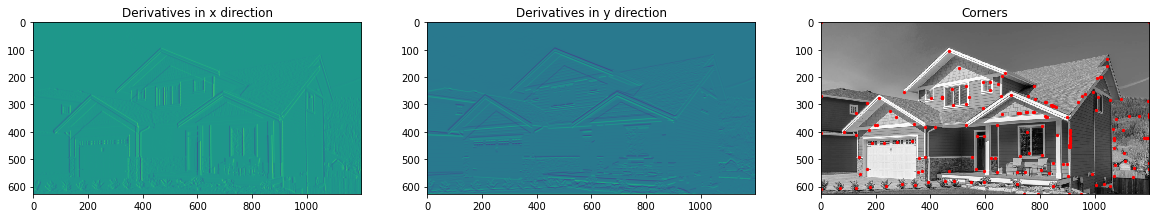

In [8]:
show_haris_corner_results(img_house, 10, 50_000)

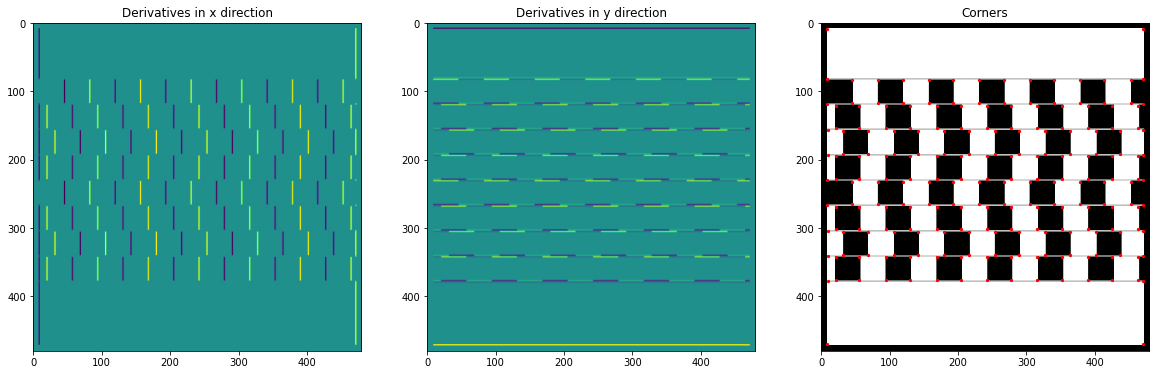

In [9]:
show_haris_corner_results(img_checkerboard, 1, 50_000)

### Rotate images

#### 45 degrees

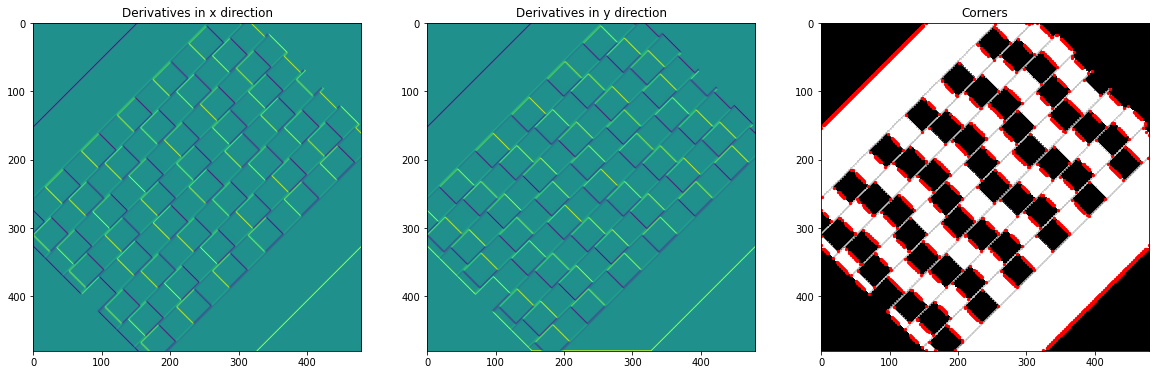

In [10]:
rotated_img = np.array(Image.fromarray(img_checkerboard).rotate(45))

show_haris_corner_results(rotated_img, 1, 50_000)

#### 90 degrees

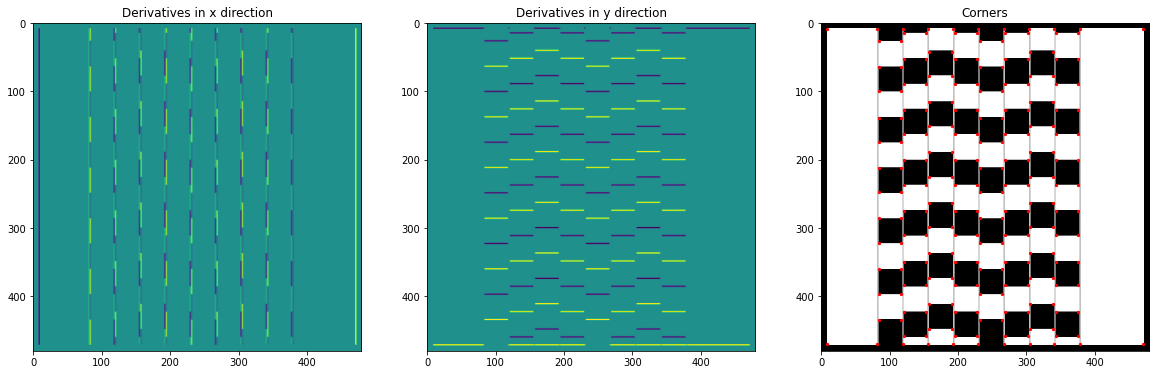

In [11]:
rotated_img = np.array(Image.fromarray(img_checkerboard).rotate(90))

show_haris_corner_results(rotated_img, 1, 50_000)

*The algorithm is not rotation-invariant. The algorithm combines the gradient in the x and y direction to find the corners, but rotating the image changes these gradients and makes the algorithm believe there are corners where there aren't any. After we ran the algorithm on rotated images of checkerboard (45 and 90 degrees), we observed that our implementation did in fact mark way more of these corners on the 45 degrees rotation. The 90 degrees performed better, since this image is fairly similiar to the original.*

## Question 1.2 (10-*pts*)
    
Now you have seen the cornerness definition of Harris on $Equation ~(12)$. Another relevant definition of cornerness is defined by  *[Shi and Tomasi](https://ieeexplore.ieee.org/document/323794)*, after the original definition of Harris. Check their algorithm and answer the following questions:
    
**1.2.1** How do they define cornerness? Write down their definition using the notations of $Equation ~(12)$. **[3pts]**
    

*Using the notations of $Equation ~(12)$, the cornerness score is given by*
$$ cornerness \ score = \min(\lambda_1, \lambda_2) = \min(A, C)$$

Then to count a corner
$$
cornerness \ score > \lambda
$$
where $\lambda$ is a pre-defined threshold.

**1.2.2** Does the Shi-Tomasi Corner Detector satisfy the following properties: translation invariance, rotation invariance, scale invariance? Explain your reasoning for each property. **[4pts]**
    

*Translation invariance: yes, this algorithm is translation invariant, as the algorithm makes use of the gradient of the image which do not chanfe with translation*

*Rotation invariance: no, the algorithm is not rotation invariant, as the algorithm looks for pixels where the gradient changes more than lambda in both the x and y direction at the same time. A rotation of the image can cause this to be true or false in places where it wasn't before.*

*Scale invariance: no, the algorithm is not scale invariant, as the algorithm looks at large changes in the gradient. Scaling the image means the gradient gets more stretched or squished, decreasing or increasing the gradient respectively. This will classify some pixels differently than the original image.*

**1.2.3** In the following scenarios, what could be the relative cornerness values assigned by Shi and Tomasi? Explain your reasoning. **[3pts]**

1. Both eigenvalues are near 0.
    
2. One eigenvalue is big and the other is near zero.
    
3. Both eigenvalues are big.

*1. The relative cornerness value would be near 0 since we take the minimum of two eogenvalues. If both eigenvalues are near zero, it indacates that the pixel lies in a region of roughly constant intensity. In other words the there are no edges or corners in that redion.*

*2. The relative cornerness value would be near 0 since we take the minimum of two eigenvalues. A big eigenvalue and a small eigenvalue mean that the intensity variation changes unilaterally, which indicates an edge.*

*3. The relative cornerness value would be big (the smaller out of 2). Two big eigenvalues mean an egde because they indicate large intensity variations in both x and y direction.*

# 2. Optical Flow - Lucas-Kanade Algorithm (35pts)

Optical flow is the apparent motion of image pixels or regions from one frame to the next, which results from moving objects in the image or from camera motion. Underlying optical flow is typically an assumption of $\textit{brightness constancy}$. That is the image values (brightness, color, etc) remain constant over time, though their 2D position in the image may change. Algorithms for estimating optical flow exploit this assumption in various ways to compute a velocity field that describes the horizontal and vertical motion of every pixel in the image. For a 2D+t dimensional case a voxel at location $(x, y, t)$ with intensity $I(x, y, t)$ will have moved by $\delta_x$, $\delta_y$ and $\delta_t$ between the two image frames, and the following image constraint equation can be given:

\begin{equation}
I(x,y,t) = I(x+\delta_x, y+\delta_y, t+\delta_t). \tag{15}
\end{equation}

Assuming the movement to be small, the image constraint at I(x, y, t) can be extended using Taylor series, truncated to first-order terms:

\begin{equation}
\tag{16}
I(x+\delta_x, y+\delta_y, t+\delta_t) = I(x,y,t)+\frac{\partial I}{\partial x}\delta_x +\frac{\partial I}{\partial y}\delta_y+\frac{\partial I}{\partial t}\delta_t
\end{equation}

Since we assume changes in the image can purely be attributed to movement, we will get:

\begin{equation}
\tag{17}
\frac{\partial I}{\partial x}\frac{\delta_x}{\delta_t} +   \frac{\partial I}{\partial y}\frac{\delta_y}{\delta_t} + \frac{\partial I}{\partial t}\frac{\delta_t}{\delta_t} = 0
\end{equation}

or

\begin{equation}
\tag{18}
I_x V_x + I_y V_y = -I_t,
\end{equation}

where $V_x$ and $V_y$ are the $x$ and $y$ components of the velocity or optical flow of $I(x,y,t)$. Further, $I_x$, $I_y$ and $I_t$ are the derivatives of the image at $(x, y, t)$ in the corresponding directions, which defines the main equation of optical flow.

Optical flow is difficult to compute for two main reasons. First, in image regions that are roughly homogeneous, the optical flow is ambiguous, because the brightness constancy assumption is satisfied by many different motions. Second, in real scenes, the assumption is violated at motion boundaries and by miscellaneous lighting, non-rigid motions, shadows, transparency, reflections, etc. To address the former, all optical flow methods make some sort of assumption about the spatial variation of the optical flow that is used to resolve the ambiguity. Those are just assumptions about the world which are approximate and consequently may lead to errors in the flow estimates. The latter problem can be addressed by making much richer but more complicated assumptions about the changing image brightness or, more commonly, using robust statistical methods which can deal with 'violations' of the brightness constancy assumption.

## Lucas-Kanade Algorithm

We will be implementing the [Lucas-Kanade method](https://www.ri.cmu.edu/pub_files/pub3/lucas_bruce_d_1981_2/lucas_bruce_d_1981_2.pdf) for Optical Flow estimation. This method assumes that the optical flow is essentially constant in a local neighborhood of the pixel under consideration. Therefore, the main equation of the optical flow can be assumed to hold for all pixels within a window centered at the pixel under consideration. Let's consider pixel $p$. Then, for all pixels around $p$, the local image flow vector $(V_x, V_y)$ must satisfy:

\begin{array}{c}
\tag{19}
  I_x(q_1)V_x + I_y(q_1)V_y = - I_t(q_1)\\
  I_x(q_2)V_x + I_y(q_2)V_y = - I_t(q_2)\\
  \vdots \\
  I_x(q_n)V_x + I_y(q_n)V_y = - I_t(q_n),\\
\end{array}

where $q_1$, $q_2$, ... $q_n$ are the pixels inside the window around $p$. $I_x(q_i)$, $I_y(q_i)$, $I_t(q_i)$ are the partial derivatives of the image $I$ with respect to position $x$, $y$ and time $t$, evaluated at the point $q_i$ and at the current time.

These equations can be written in matrix to form $Av=b$, where

\begin{equation}
\tag{20}
A = \begin{bmatrix}
I_x(q_1) & I_y(q_1)\\
I_x(q_2) & I_y(q_2)\\
\vdots   & \vdots  \\
I_x(q_n) & I_y(q_n)
\end{bmatrix},
v = \begin{bmatrix}
V_x\\ V_y
\end{bmatrix}, \mbox{ and }
b = \begin{bmatrix}
-I_t(q_1)\\
-I_t(q_2)\\
\vdots   \\
-I_t(q_n)
\end{bmatrix}.
\end{equation}

This system has more equations than unknowns and thus it is usually over-determined. The Lucas-Kanade method obtains a compromise solution by the weighted-least-squares principle. Namely, it solves the $2\times 2$ system as

\begin{equation}
\tag{21}
A^T A v = A^T b
\end{equation}

or

\begin{equation}
v = (A^T A)^{-1} A^T b.
\label{eqA} \tag{22}
\end{equation}

## Question 2.1 (30-*pts*)
    
For this assignment, you will be given three pairs of images: **sphere1.ppm**, **sphere2.ppm**; **car1.jpg**, **car2.jpg**; and **plant1.png**, **plant2.png**. You should estimate the optical flow between these two pairs. That is, you will get optical flow for sphere images, and for car and plant images separately. Implement the Lucas-Kanade algorithm using the following steps.

    
1. Divide  input  images  on  non-overlapping  regions,  each  region  being  $20\times 20$.
    
    
2. For each region compute $A$, $A^T$ and $b$. Then, estimate optical flow as given in Equation 22.
    
    
3. When you have estimation for optical flow $(V_x, V_y)$ of each region, you should display the results. There is a **matplotlib** function `quiver` which plots a set of two-dimensional vectors as arrows on the screen. Try to figure out how to use this to show your optical flow results.

<em>Note</em>: You are allowed to use `scipy.signal.convolve2d` to perform convolution.
Include a demo function to run your code.

**Hint**: You can use regions that are $20\times 20$ pixels that are non-overlapping. That is, if input images are $256\times 256$, you should have an array of $12\times 12$ optical flow vectors at the end of your procedure. As we consider $20\times 20$ regions, your matrix $\textbf{A}$ will have the following size $400\times 2$, and the vector $\mathbf{b}$ will be $400\times 1$.

**Hint**: Carefully read the documentation of **matplotlib**'s function `quiver`. By default, the angles of the arrows are 45 degrees counter-clockwise from the horizontal axis. This means your arrows might point in the wrong direction! Also, play around with the arrow scaling.

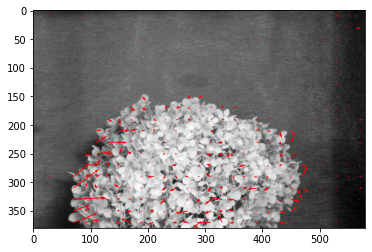

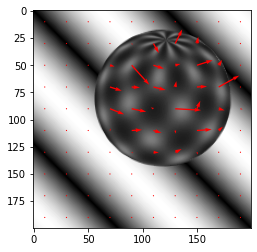

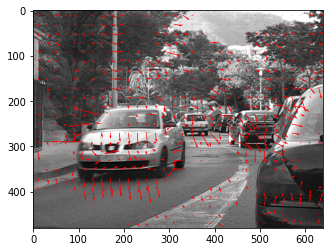

In [18]:
def load_images(name_image_t0, name_image_t1, image_dir="./data/"):
    # Load the two images
    I_t0 = cv2.imread(image_dir + name_image_t0, 0)
    I_t1 = cv2.imread(image_dir + name_image_t1, 0)

    # Convert the to np.float32
    I_t0 = I_t0.astype(np.float32)
    I_t1 = I_t1.astype(np.float32)

    return I_t0, I_t1


def calculate_derivatives(I_t0, I_t1):
    """
    Obtain x, y and time derivatives of an image.
    """
    x_kernel = np.array([[-1, 1], [-1, 1]])
    y_kernel = np.array([[-1, -1], [1, 1]])
    kernel_t = np.array([[1, 1], [1, 1]])

    fx = signal.convolve2d(I_t0, x_kernel, mode="same")
    fy = signal.convolve2d(I_t0, y_kernel, mode="same")
    ft = signal.convolve2d(I_t0, kernel_t, mode="same") - signal.convolve2d(I_t1, kernel_t, mode="same")
    return fx, fy, ft


# Function that separates the image into subregions
def calculate_subregions(I_t0, I_x, I_y, I_t, region_size):
    """
    input: I_t0, I_x, I_y, I_t, region_size
    I_t0: image at time t0
    I_x: image x-derivative
    I_y: image y-derivative
    I_t: image time derivative
    region_size: size of the subregions

    output: sub_I_x, sub_I_y, sub_I_t
    sub_I_x: subregions of the image x-derivative
    sub_I_y: subregions of the image y-derivative
    sub_I_t: subregions of the image time derivative
    """

    # --------------
    # YOUR CODE HERE
    # --------------
    raise NotImplementedError()


# Function that calulates subregions given corners
def calculate_subregions_for_corners(I_x, I_y, I_t, r, c, region_size):
    """
    Input: I_x, I_y, I_t, r, c, region_size
    I_x, I_y, I_t: image derivatives
    r, c: corners of the subregions
    region_size: size of the subregions

    Output: sub_I_x, sub_I_y, sub_I_t
    sub_I_x, sub_I_y, sub_I_t: subregions of the image derivatives
    """
    # --------------
    # YOUR CODE HERE
    # --------------
    raise NotImplementedError()


# Function that computes A, A.T and b for each subregion. Then, estimate
# optical flow (Vx, Vt) as given in Equation 22.
def calculate_flow_vectors(I_x, I_y, I_t):
    """
    Calculate the local image flow vector (Vx, Vy) for each subregion by
    solving the linear system defined above.

    Input: I_x, I_y, I_t
    I_x, I_y, I_t: image derivatives

    Output: Vx, Vy
    Vx, Vy: Two lists containing, respectively, Vx, Vy of each subregion
    """
    A = np.vstack((I_x.flatten(), I_y.flatten())).T
    b = -I_t.flatten().T
    Vx, Vy = np.linalg.inv(A.T @ A) @ (A.T @ b)
    return Vx, Vy
    


# Function that plots the optical flow vectors
def plot_optical_flow(subregion_indices, V_x, V_y):
    """
    Input: subregion_indices, V_x, V_y
    subregion_indices: indices of the subregions
    V_x, V_y: optical flow vectors
    """
    X = []
    Y = np.array([-subregion_indices[0,0].shape[0]/2])

    for i in range(subregion_indices.shape[0]):
        X.append(subregion_indices[0,0].shape[1]/2)
        Y = np.append(Y, [Y[-1]+subregion_indices[i,0].shape[0] for _ in range(subregion_indices.shape[1])])
        for j in range(1,subregion_indices.shape[1]):
            X.append(X[-1]+subregion_indices[i,j].shape[1])
    Y = Y[1:]
    X = np.array(X)
    joined = np.concatenate(subregion_indices, axis=1)
    plt.imshow(np.concatenate(joined, axis=1), cmap="gray")
    plt.quiver(X, Y, V_x, V_y, angles="xy", scale=subregion_indices.shape[0], color="red", linewidth=subregion_indices.shape[0]/3000)
    plt.show()


# --------------
# YOUR CODE HERE
# --------------
# Add the remainder of your code here. If needed, feel free to define more functions.

def splitimage(img, region_size):
    blocks = np.ones(((img.shape[0]//region_size), (img.shape[1]//region_size),region_size, region_size))
    #splitimg = np.split(img, range(region_size, img.shape[0], region_size))
    for i in range(region_size,img.shape[0]+1,20):
        for j in range(region_size,img.shape[1]+1,20):
            blocks[int(i/region_size)-1,int(j/region_size)-1] = img[i-region_size:i, j-region_size:j]
    return blocks

def calculate_opticalflow(img0_name, img1_name, image_dir="./data/", window_size=20):
    I_t0, I_t1 = load_images(img0_name, img1_name, image_dir=image_dir)

    split_I_t0 = splitimage(I_t0, window_size)
    split_I_t1 = splitimage(I_t1, window_size)

    V_x = np.zeros(split_I_t0.shape[:2])
    V_y = np.zeros(split_I_t0.shape[:2])

    for i in range(split_I_t0.shape[0]):
        for j in range(split_I_t0.shape[1]):
            sx, sy, st = calculate_derivatives(split_I_t0[i,j], split_I_t1[i, j])
            V_x[i, j], V_y[i, j] = calculate_flow_vectors(sx, sy, st)

    return split_I_t0, V_x, V_y


plot_optical_flow(*calculate_opticalflow("plant1.png", "plant2.png"))

plot_optical_flow(*calculate_opticalflow("sphere1.ppm", "sphere2.ppm"))
        
plot_optical_flow(*calculate_opticalflow("car1.jpg", "car2.jpg"))


*YOUR ANSWER HERE*

## Question 2.2 (5-*pts*)

Now you have seen one of the optical flow estimation methods developed by Lucas and Kanade. There are several more methods in the literature. The *[Horn-Schunck method](https://www.sciencedirect.com/science/article/abs/pii/0004370281900242)* is one of them. Check their method, compare it to Lucas-Kanade and answer the following questions:

**2.2.1** At what scale do the algorithms operate; i.e local or global? Explain your answer.


**2.2.2** How do the algorithms behave at flat regions? Explain differences/similarities.

*YOUR ANSWER HERE*

# 3. Feature Tracking (20-pts)

In this part of the assignment, you will implement a simple feature-tracking algorithm. The aim is to extract visual features, like corners, and track them over multiple frames.

## Question 3.1 (18-*pts*)

**3.1.1** Implement a simple feature-tracking algorithm by following below steps **[12pts]**:
    
1. Locate feature points on the first frame by using the Harris Corner Detector, that you implemented in Section 1.

2. Track these points using the Lucas-Kanade algorithm for optical flow estimation, that you implemented in the Section 2.
    
    
**3.1.2** Prepare a video for each sample image sequences. These videos should visualize the initial feature points and the optical flow. Test your implementation and prepare visualization videos for **basketball** and **toy** samples. **[6pts]**

Include a demo function to run your code.

35
[5.080582674523938, 50.00242330950066, 51.00242330950066, 53.00242330950066, 68.85304019675681, 130.74883661589485, 157.97560631892492] [344.29104558150755, 18.98714211066714, 16.98714211066714, -0.012857889332860088, 368.90635591612283, 192.8550483765938, 456.31295233237756]
36
[5.13271137302913, 50.00415216189846, 51.00415216189846, 53.00415216189846, 68.93509805062291, 130.3698558318792, 157.84409227981777] [342.040760813783, 18.98197097496797, 16.98197097496797, -0.01802902503202799, 368.39099243309016, 192.8247732073778, 456.1914626254674]
37
[5.209233257935715, 50.00886904992845, 51.00886904992845, 53.00886904992845, 69.04735741789995, 130.04311465216657, 157.65439426666606] [341.6142790277317, 18.97747347435074, 16.97747347435074, -0.02252652564925743, 367.32256162603204, 192.79869332892054, 456.0703579378364]
38
[5.273396363190502, 50.00906416071523, 51.00906416071523, 53.00906416071523, 69.13276012231275, 130.10380589937094, 157.53061457442382] [341.3418875765642, 18.972142

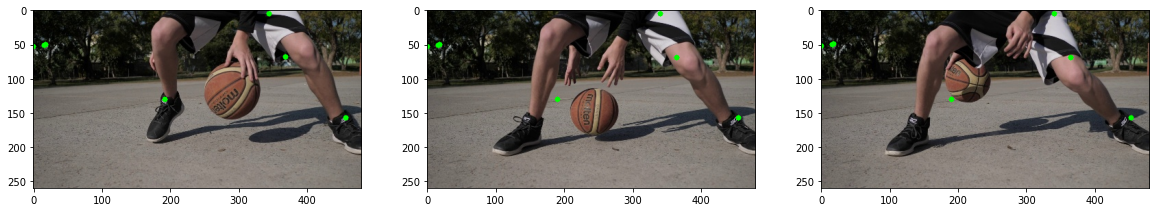

In [13]:
from glob import glob
from pathlib import Path

image_seq = "basketball"
# image_seq = "toy"
threshold_dict = {
    "basketball": 5e7,
    "toy": 1e7,
}
root_dir = f"./data/{image_seq}/"
img_dirs = sorted(glob(root_dir + "*.jpg"))
first_img, last_img = 35, 46
imgs_to_plot = [36, 41, 46]
plot_or_not = np.array([False for _ in img_dirs])
plot_or_not[imgs_to_plot] = True
window_size = 20

# Keypoints on first frame
img = img2gray(img_dirs[first_img])
h, w = img.shape
h = (h // window_size) * window_size
w = (w // window_size) * window_size
img = img[:h, :w]
_, r, c = haris_corner_detector(img, 1, threshold_dict[image_seq])

def get_outputs():
    outputs = []
    for i in range(first_img, last_img + 1):
        print(i)
        img_2 = (plt.imread(img_dirs[i + 1]))[:h, :w]

        _, V_x, V_y = calculate_opticalflow(
            Path(img_dirs[i]).name,
            Path(img_dirs[i + 1]).name,
            image_dir=root_dir,
            window_size=window_size,
        )

        # update r and c
        for j, (y, x) in enumerate(zip(r, c)):
            # print(V_y[np.clip(int(y), 0, h) // window_size, np.clip(int(x), 0, w) // window_size],
            #       V_x[np.clip(int(y), 0, h) // window_size, np.clip(int(x), 0, w) // window_size])
            r[j] += V_y[np.clip(int(y), 0, h) // window_size, np.clip(int(x), 0, w) // window_size]
            c[j] += V_x[np.clip(int(y), 0, h) // window_size, np.clip(int(x), 0, w) // window_size]
        
        print(r[:10], c[:10])

        # draw keypoints on image
        for y, x in zip(r, c):
            img_2 = cv2.circle(img_2, (int(x), int(y)), radius=1, color=(0, 255, 0), thickness=5)

        if plot_or_not[i + 1]:
            outputs.append(img_2)
    
    return outputs

outputs = get_outputs()

fig, axs = plt.subplots(1, len(imgs_to_plot), figsize=(20, 10))

for i, output in enumerate(outputs):
    axs[i].imshow(output)


*YOUR ANSWER HERE*

## Question  3.2 (2-*pts*)

Why do we need feature tracking even though we can detect features for each and every frame?

*YOUR ANSWER HERE*

# X Individual Contribution Report *(Mandatory)*

Because we want each student to contribute fairly to the submitted work, we ask you to fill out the textcells below. Write down your contribution to each of the assignment components in percentages. Naturally, percentages for one particular component should add up to 100% (e.g. 30% - 30% - 40%). No further explanation has to be given.


Name:

Contribution on research: \
Contribution on programming: \
Contribution on writing:

Name:

Contribution on research: \
Contribution on programming: \
Contribution on writing:

Name:

Contribution on research: \
Contribution on programming: \
Contribution on writing:

Name:

Contribution on research: \
Contribution on programming: \
Contribution on writing:

# - End of notebook -